In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
os.chdir('C:\\Users\\axour\\OneDrive\\Documents\\Courses\\IEAP\\Python-R-Git\\Series01-Python')
data = np.loadtxt(ECGu.txt)


print(data[:10])   # check first 10 samples


[[-275. -119. -119.]
 [-275. -119. -119.]
 [-275. -118. -121.]
 [-275. -121. -112.]
 [-273. -120. -105.]
 [-274. -124. -101.]
 [-274. -126.  -86.]
 [-273. -126.  -73.]
 [-270. -125.  -70.]
 [-274. -120.  -80.]]


Loaded ECGu.txt with shape (6500, 3) (samples × leads).


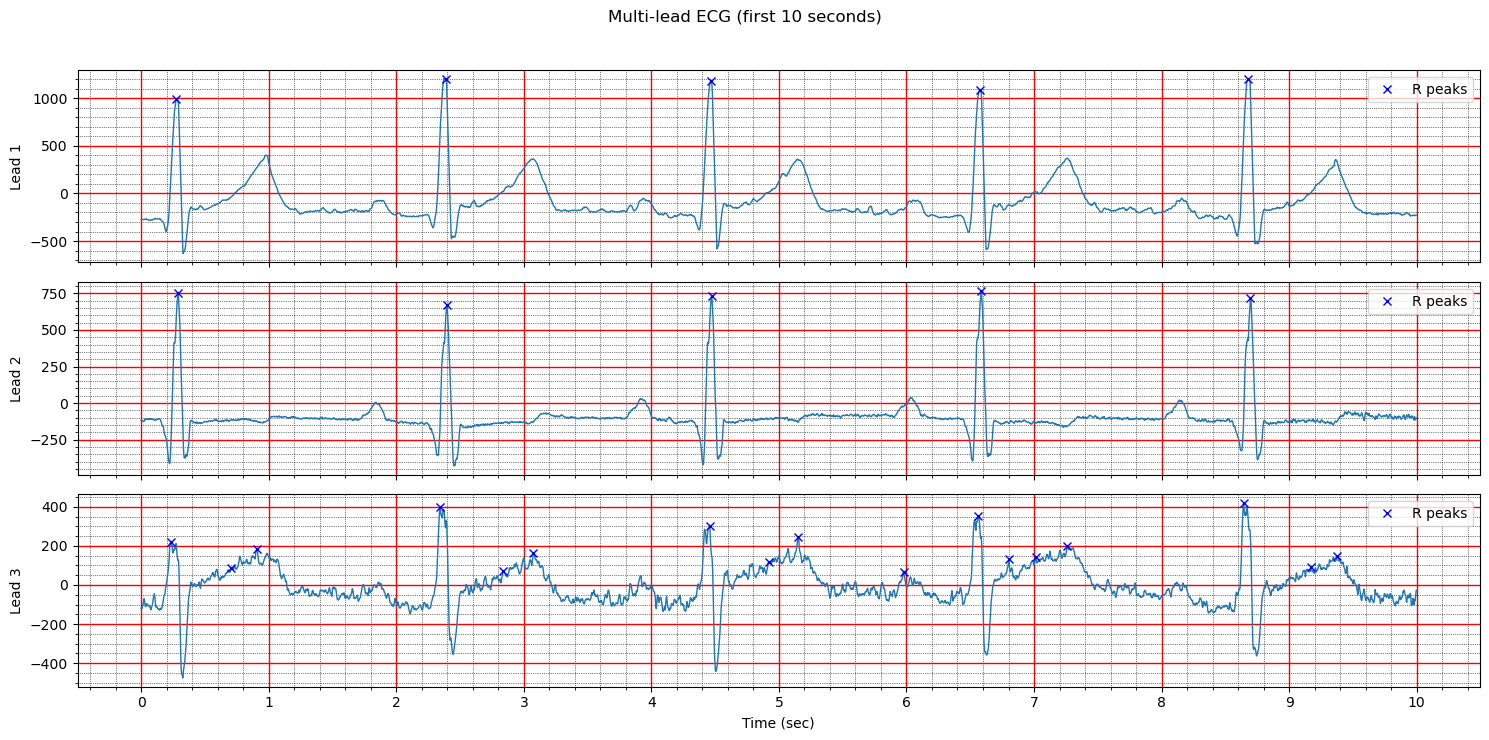

In [43]:
#!/usr/bin/env python3
"""
plot_multilead_ecg.py

Plots each ECG lead separately from ECGu.txt.
Detects R-peaks on each lead.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks

# --- Settings ---
ECG_FILE = "ECGu.txt"
fs = 360            # Hz (adjust if your dataset uses another sampling rate)
use_seconds = 10    # seconds to plot
qrs_refrac_ms = 200
# ----------------

def load_ecg(filename):
    if os.path.exists(filename):
        data = np.loadtxt(filename)
        if data.ndim == 1:
            data = data.reshape(-1, 1)  # single channel
        print(f"Loaded {filename} with shape {data.shape} (samples × leads).")
        return data
    else:
        from scipy.misc import electrocardiogram
        ecg = electrocardiogram()
        return ecg.reshape(-1, 1)

def extract_segment(ecg, fs, duration_sec):
    n = int(fs * duration_sec)
    if ecg.shape[0] < n:
        pad = np.zeros((n, ecg.shape[1]))
        pad[:ecg.shape[0], :] = ecg
        return pad
    else:
        return ecg[:n, :]

def plot_ecg_signal(time, sig, ax, label="ECG"):
    ax.plot(time, sig, linewidth=1)
    min_t, max_t = int(np.min(time)), int(np.ceil(np.max(time)))
    ax.set_xticks(np.arange(min_t, max_t + 1))
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', color='red', linewidth=1.0)
    ax.grid(which='minor', linestyle=':', color='black', linewidth=0.5)
    ax.set_ylabel(label)

def main():
    ecg = load_ecg(ECG_FILE)
    seg = extract_segment(ecg, fs, use_seconds)
    ts = np.arange(seg.shape[0]) / fs

    fig, axes = plt.subplots(seg.shape[1], 1, figsize=(15, 2.5 * seg.shape[1]), sharex=True)

    if seg.shape[1] == 1:
        axes = [axes]

    for lead in range(seg.shape[1]):
        sig = seg[:, lead]
        ax = axes[lead]
        plot_ecg_signal(ts, sig, ax, label=f"Lead {lead+1}")
        # detect R peaks on this lead
        r_inds = find_r_peaks(sig, fs, threshold=0.6, qrs_refrac_ms=qrs_refrac_ms)
        ax.plot(ts[r_inds], sig[r_inds], 'x', color='blue', label="R peaks")
        ax.legend(loc="upper right")

    axes[-1].set_xlabel("Time (sec)")
    plt.suptitle("Multi-lead ECG (first 10 seconds)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if __name__ == "__main__":
    main()


Loaded ECGu.txt with shape (6500, 3) (samples × leads).


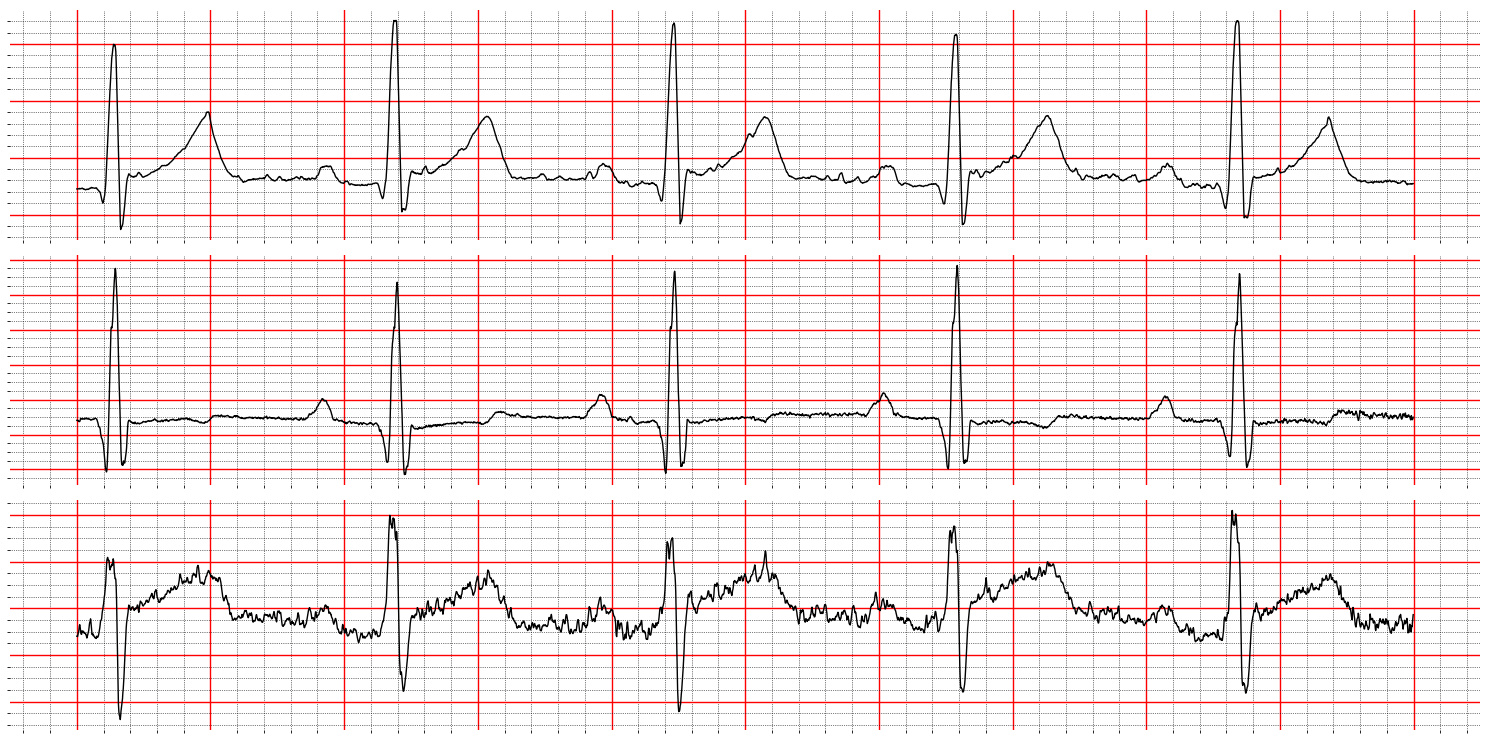

In [44]:
#!/usr/bin/env python3
"""
plot_multilead_ecg_clean.py

Plots multi-lead ECG with full-page ECG-style grid, no text/labels.
"""

import os
import numpy as np
import matplotlib.pyplot as plt

# --- Settings ---
ECG_FILE = "ECGu.txt"
fs = 360            # Hz (set to your dataset’s sampling frequency)
use_seconds = 10    # seconds to plot
# ----------------

def load_ecg(filename):
    if os.path.exists(filename):
        data = np.loadtxt(filename)
        if data.ndim == 1:
            data = data.reshape(-1, 1)  # single channel
        print(f"Loaded {filename} with shape {data.shape} (samples × leads).")
        return data
    else:
        from scipy.misc import electrocardiogram
        ecg = electrocardiogram()
        return ecg.reshape(-1, 1)

def extract_segment(ecg, fs, duration_sec):
    n = int(fs * duration_sec)
    if ecg.shape[0] < n:
        pad = np.zeros((n, ecg.shape[1]))
        pad[:ecg.shape[0], :] = ecg
        return pad
    else:
        return ecg[:n, :]

def plot_ecg_signal(time, sig, ax):
    ax.plot(time, sig, linewidth=1, color="black")
    min_t, max_t = int(np.min(time)), int(np.ceil(np.max(time)))
    ax.set_xticks(np.arange(min_t, max_t + 1))
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', color='red', linewidth=1.0)
    ax.grid(which='minor', linestyle=':', color='black', linewidth=0.5)
    # remove labels, ticks, spines
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)

def main():
    ecg = load_ecg(ECG_FILE)
    seg = extract_segment(ecg, fs, use_seconds)
    ts = np.arange(seg.shape[0]) / fs

    fig, axes = plt.subplots(seg.shape[1], 1, figsize=(15, 2.5 * seg.shape[1]), sharex=True)

    if seg.shape[1] == 1:
        axes = [axes]

    for lead in range(seg.shape[1]):
        sig = seg[:, lead]
        ax = axes[lead]
        plot_ecg_signal(ts, sig, ax)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Loaded ECGu.txt with shape (6500, 3) (samples × leads).
Applying gain factor: 0.00 to match ~1.0 mV amplitude.
✅ Realistic ECG strip saved as ecg_strip.png


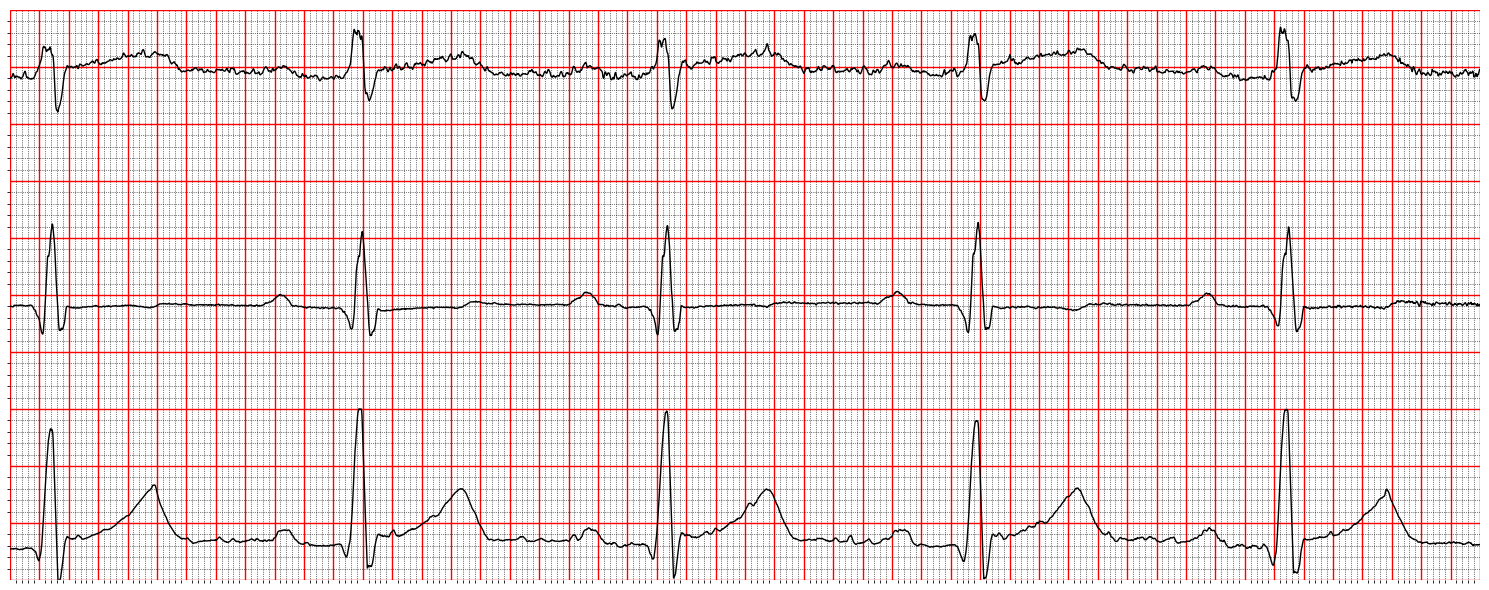

In [1]:
#!/usr/bin/env python3
"""
plot_multilead_ecg_realistic_png.py

Multi-lead ECG realistic plot:
- Continuous ECG paper grid (red major, black minor),
- Calibrated amplitude (10 mm/mV) and time (25 mm/s),
- Stacked leads with vertical offsets,
- Exported as PNG.
"""

import os
import numpy as np
import matplotlib.pyplot as plt

# --- User settings ---
ECG_FILE = "ECGu.txt"
OUTPUT_FILE = "ecg_strip.png"
fs = 360                # Sampling frequency in Hz
use_seconds = 10        # Duration to plot
lead_spacing_mV = 2.0   # Vertical spacing between leads (mV)
target_amplitude_mV = 1.0  # Typical amplitude scaling if units are arbitrary
# ----------------------

# ECG paper grid calibration
time_per_small = 0.04     # 1 small box = 0.04 s (25 mm/s)
time_per_large = 0.20     # 1 large box = 0.2 s
amp_per_small = 0.1       # 1 small box = 0.1 mV
amp_per_large = 0.5       # 1 large box = 0.5 mV

def load_ecg(filename):
    """Load ECG data from file."""
    if os.path.exists(filename):
        data = np.loadtxt(filename)
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        print(f"Loaded {filename} with shape {data.shape} (samples × leads).")
        return data
    else:
        from scipy.misc import electrocardiogram
        ecg = electrocardiogram()
        return ecg.reshape(-1,1)

def extract_segment(ecg, fs, duration_sec):
    n = int(fs * duration_sec)
    if ecg.shape[0] < n:
        pad = np.zeros((n, ecg.shape[1]))
        pad[:ecg.shape[0], :] = ecg
        return pad
    else:
        return ecg[:n, :]

def main():
    ecg = load_ecg(ECG_FILE)
    seg = extract_segment(ecg, fs, use_seconds)
    ts = np.arange(seg.shape[0]) / fs
    n_leads = seg.shape[1]

    # --- Automatic gain scaling ---
    max_amp = np.max(np.abs(seg))
    if max_amp == 0:
        max_amp = 1.0
    gain = target_amplitude_mV / max_amp
    print(f"Applying gain factor: {gain:.2f} to match ~{target_amplitude_mV} mV amplitude.")

    fig, ax = plt.subplots(figsize=(15, 6))

    # Plot each lead with vertical offset
    for i in range(n_leads):
        offset = i * lead_spacing_mV
        ax.plot(ts, seg[:, i]*gain + offset, color="black", linewidth=1)

    # --- ECG paper grid ---
    ax.set_xlim([ts[0], ts[-1]])
    ymin = -amp_per_large
    ymax = (n_leads-1)*lead_spacing_mV + amp_per_large
    ax.set_ylim([ymin, ymax])

    # Vertical lines
    ax.set_xticks(np.arange(0, ts[-1]+time_per_large, time_per_large))
    ax.set_xticks(np.arange(0, ts[-1]+time_per_small, time_per_small), minor=True)

    # Horizontal lines
    ax.set_yticks(np.arange(ymin, ymax+amp_per_large, amp_per_large))
    ax.set_yticks(np.arange(ymin, ymax+amp_per_small, amp_per_small), minor=True)

    # Grid style
    ax.grid(which='major', linestyle='-', color='red', linewidth=1.0)
    ax.grid(which='minor', linestyle=':', color='black', linewidth=0.5)

    # Hide axes labels, ticks, spines
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches="tight")
    print(f"✅ Realistic ECG strip saved as {OUTPUT_FILE}")

if __name__ == "__main__":
    main()
